# Import Libraries

Zuerst binden wir wie immer die Benutzen Bibliotheken ein.

In [1]:
from netgen.geom2d import *
import scipy
import scipy.sparse.linalg

from scipy.stats import unitary_group
from ngsolve import *
from ngsolve.webgui import Draw
import numpy as np
from scipy.linalg import block_diag
import time


import matplotlib.pyplot as plt

Unterliegender Block wird noch in eigene Library gepackt

In [2]:
def gen_rand_mat(eig, compl = False):
    n = eig.shape[0]
    if compl:
        B = np.random.rand(n,n) + np.random.rand(n,n)*compl*1j
    else:
        B = np.random.rand(n,n)
    return np.linalg.inv(B)@np.diag(eig)@B



def error(eig_1, eig_2):
    return np.linalg.norm(eig_1 - eig_2)

def runtime(f, A):
    start = time.time()
    S = f(A)
    end = time.time()
    return end - start

def runtime_error(f, A, eigv, k = 0):
    if k == 0:
        start = time.time()
        S = f(A)[1]
        end = time.time()
        S = error(S, eigv)
    else:
        start = time.time()
        S = f(lambda x: A@x, k)[1]
        end = time.time()
        S = error(S, eigv)
    return end - start, S


def generate_rand_eigvals(n):
    return np.sort(5000*np.random.rand(n)-25)

def QR_hesse(A,tol=1e-12):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count

def gen_hess(n, compl = False):
    if compl:
        a = np.random.rand(n) + np.random.rand(n)*1j
        b = np.random.rand(n-1) + np.random.rand(n-1)*1j
        c = np.random.rand(n-1) + np.random.rand(n-1)*1j
        return np.diag(b, -1) + np.diag(a,0) + np.diag(c, 1)
    else:
        a = np.random.rand(n)
        b = np.random.rand(n-1)
        c = np.random.rand(n-1)
        return np.diag(b, -1) + np.diag(a,0) + np.diag(c, 1)
    
  
def gen_hermite(eig, compl = False):
    n = eig.shape[0]
    B = unitary_group.rvs(n)
    return B.T.conj()@np.diag(eig)@B

# Implemented QR-Algorithm

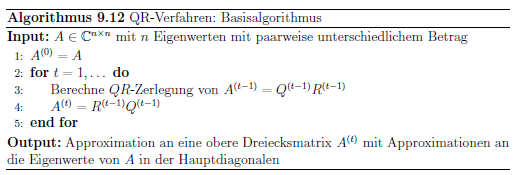


Diese simple Version ist schnell implementiert. Zur Fehler- und Laufzeittestung kommen wir am Ende des Abschnitts.

In [3]:
def QR_simple(A,tol = 1e-6):  #Toleranz wird auf Standardwert gesetzt, falls im Aufruf nicht anders angegeben
    n = A.shape[1]
    count = 0
    while max([abs(A[i,i-1]) for i in range(1,n)]) > tol:   #Abbruchbedingung, in dieser Implementation auch Aufwändig
        Q,R = np.linalg.qr(A)  #Für die QR-Zerlegung wurde eine Funktion aus dem Numpy-Linalg Paket verwendet
        A = R@Q                #Der wesentliche Schritt
        count +=1              
    return A, sorted(np.diag(A)), count

Hier Algorithmus Header Einfügen

In [4]:
def QR_shift(A,tol=1e-10):
    n = A.shape[1]                                    #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                         #i durchläuft {1,...,n} rückwärts 
        while abs(A[i,i-1]) > tol:                    #in der Zeile ist immer labmda_i/lambda_{i-1} am größten
            rho = A[i,i]                              #Der Shift-Parameter
            Q,R = np.linalg.qr(A-rho*np.identity(n))  #QR-Zerlegung der geshifteten Matrix
            A = R@Q + rho*np.identity(n)              #RQ + Rückshift
            count +=1
        A[i,:i-n] = 0                                 #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count

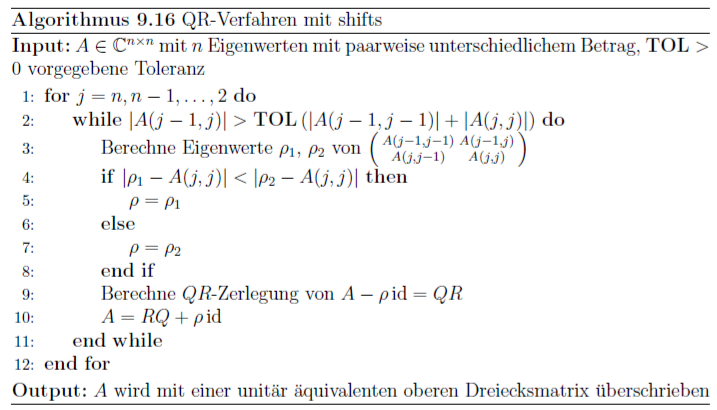

Die effizienteste Wahl des Shifts

In [5]:
def QR_shift2(A,tol=1e-12):
    n = A.shape[1]                                                #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                                     #i durchläuft {1,...,n} rückwärts
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):  #Hier ein kleiner Fehler im Skript
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])             #Eigenwerte werden berechnet
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count

In [6]:
n_arr = [10*i for i in range(1,10)]                                 #Dimension des Problems

k = len(n_arr)
eigv_array = []
for i in range(k):
    eigv_array.append(np.sort(5000*np.random.rand(n_arr[i])-250)) #Eigenwerte werden zufällig generiert

In [7]:
mat_array = []

for i in range(k):
    mat_array.append(gen_rand_mat(eigv_array[i]))

In [8]:
time_1 = [0]*k
time_2 = [0]*k
time_3 = [0]*k

error_1 = [0]*k
error_2 = [0]*k
error_3 = [0]*k
for i in range(k):
    #time_1[i], error_1[i] = runtime_error(QR_simple, mat_array[i], eigv_array[i])
    time_2[i], error_2[i] = runtime_error(QR_shift, mat_array[i], eigv_array[i])
    time_3[i], error_3[i] = runtime_error(QR_shift2, mat_array[i], eigv_array[i])

<IPython.core.display.Javascript object>


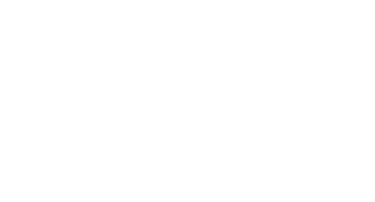

In [9]:
%matplotlib notebook

#plt.semilogy(n_arr, time_1, 'o', label = "Zeit ohne shifts")
plt.semilogy(n_arr, time_2, 'o', label = "Zeit mit shifts1")
plt.semilogy(n_arr, time_3, 'o', label = "Zeit mit shifts2")

plt.ylabel("time")
plt.xlabel("$n$")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


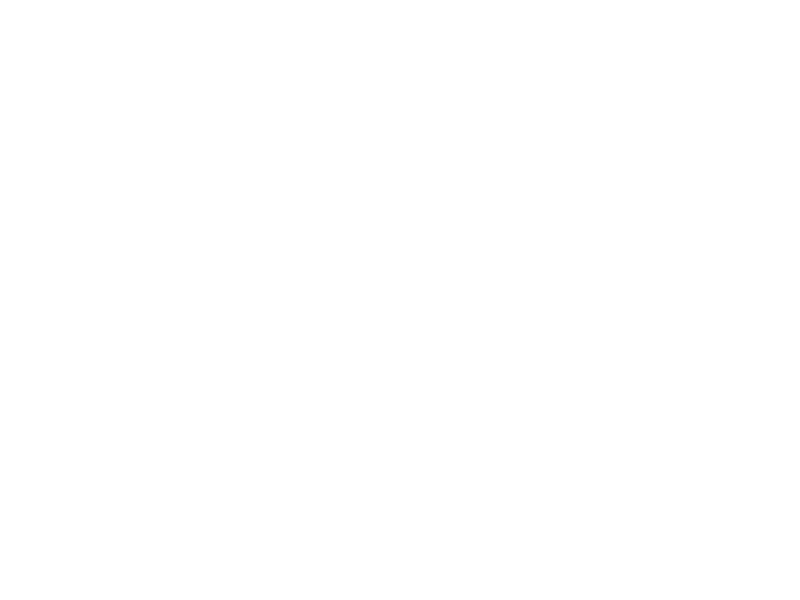

In [10]:
%matplotlib notebook

plt.semilogy(n_arr, error_1, '-o', label = "Fehler ohne shifts")
plt.semilogy(n_arr, error_2, '-o', label = "Fehler mit shifts1")
plt.semilogy(n_arr, error_3, '-o', label = "Fehler mit shifts2")

plt.ylabel("Error")
plt.xlabel("$n$")
plt.legend()
plt.show()

## Special-Case: QR-Algorithm applied to a Hessian-Matrix

Hier können wir Givens-Rotation verwenden um die QR-Zerlegung durchzufühern und einen speed-up zu bekommen.

In [11]:
def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):
            t = A[i+1,i]/abs(A[i,i])
            root = (1+abs(t)**2)**(1/2)
            c = A[i,i]/(abs(A[i,i])*root)
            s = t/root
        else:
            t = A[i,i]/abs(A[i+1,i])
            root = (1+abs(t)**2)**(1/2)
            s = A[i+1,i]/(abs(A[i+1,i])*root)
            c = t/root
            
        M = np.array([[c.conj(), s.conj()], [-s, c]])
        G = block_diag(np.eye(i,i), M, np.eye(n-i-2, n-i-2))
        Q = G@Q
        for j in range(i, n):
            temp_1 = A[i,j]
            A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j]
            A[i+1,j] = -s*temp_1 + c*A[i+1,j]
    return Q.T.conj(), A

Wir können nun auch Vergleichen.

In [12]:
n_arr = [10*i for i in range(1,8)]       #Dimension des Problems

k = len(n_arr)
    
mat_array = []

for i in range(k):
    mat_array.append(gen_hess(n_arr[i])) #Hesseberg-Matrizen der Dimension n werden erstellt

In [13]:
time_1 = [0]*k
time_2 = [0]*k

for i in range(k):
    time_1[i] = runtime(QR_hesse, mat_array[i])
    time_2[i] = runtime(QR_shift2, mat_array[i])

<IPython.core.display.Javascript object>


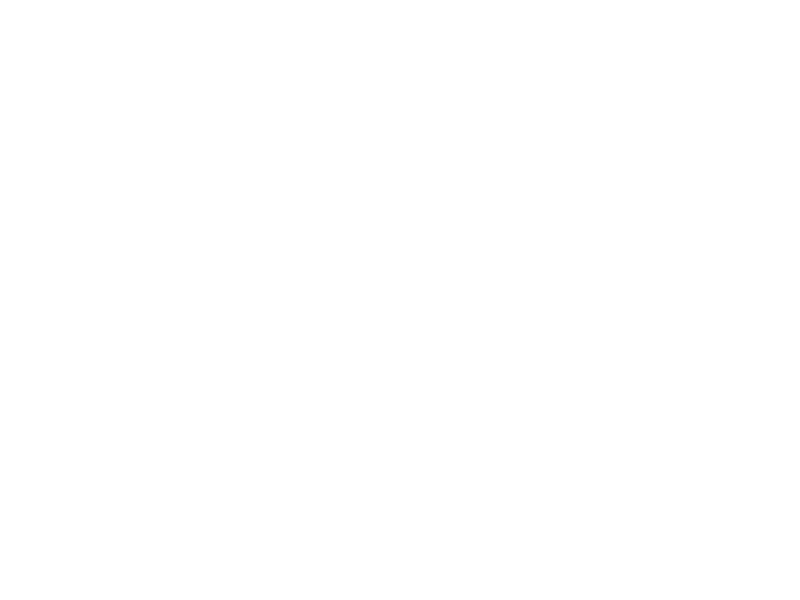

In [14]:
%matplotlib notebook

plt.semilogy(n_arr, time_1, '-o', label = "QR-Verfahren für Hessebergmatrizen")
plt.semilogy(n_arr, time_2, '-o', label = "QR-Verfahren")

plt.legend()
plt.show()

Wie man erkennt ist der Vorimplementierte QR-Algorithmus wohl immer noch effizienter.

## Lanczos-Algorithm and its shortcomings

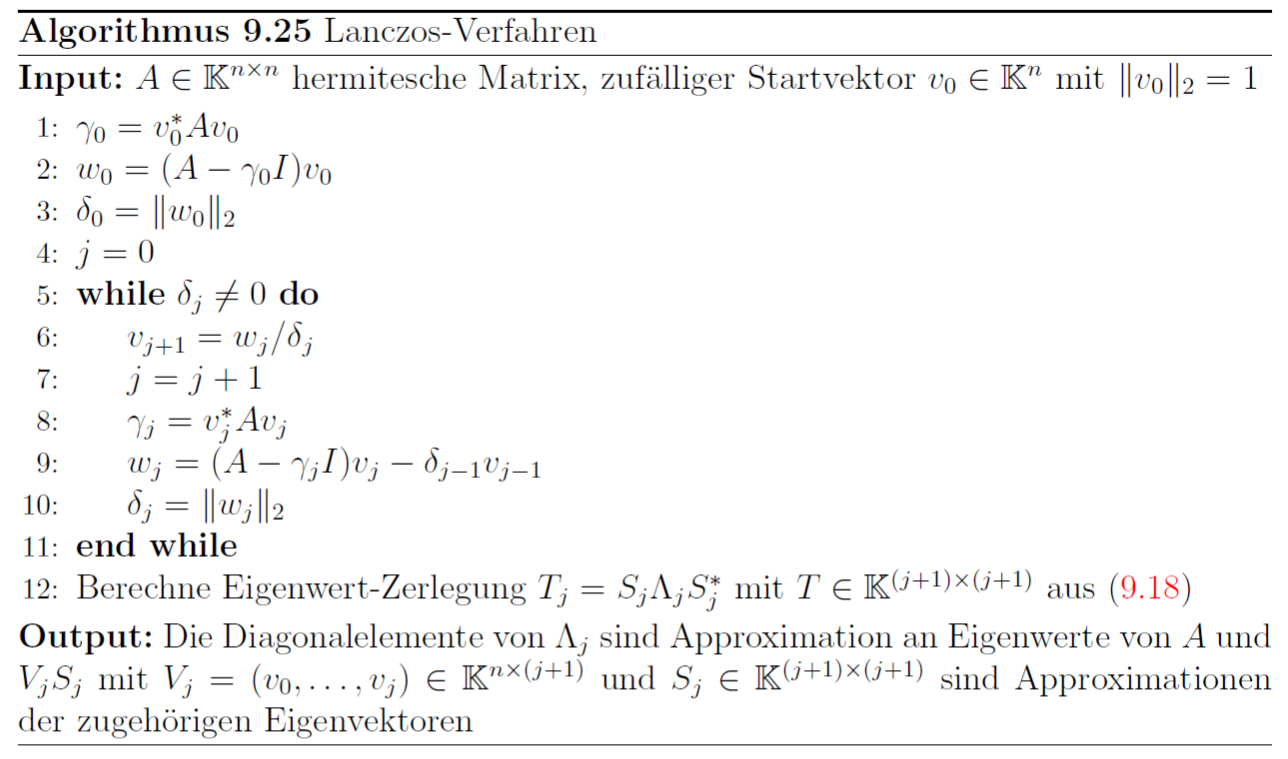

In [15]:
def lanczos(A,k = 0):                                         #k sei die Anzahl der zu berechnenden Eigenwerte
    n = A.shape[1]
    if k == 0:                                                #Wird keine Anzahl angegeben werden alle berechnet
        k = n
        
    v0 = np.random.rand(n)                                    #Randomisierter Startvektor wird gewählt
    v = [v0/np.linalg.norm(v0)]                               #Normieren sowie Listenerstellung
    gam = [v[0].T.conj()@A@v[0]]                              #Berechnung von gamma und Listenerstellung
    w = (A - gam[0]*np.identity(n))@v[0]                      #Berechnung des Vektors w
    delta = [np.linalg.norm(w)]                               #Zugehörige Norm sowie Listenerstellung
    i = 0
    while delta[i] > 1e-10 and i < k-1:                       #Sobald delta zu 0 wird haben wir unsere ONB aus Eigenvektoren
        v.append(w/delta[i])                                  #Liste der v wird erweitert
        i +=1
        gam.append(v[i].T.conj()@A@v[i])
        w = (A - gam[i]*np.identity(n))@v[i] - delta[i-1]*v[i-1]
        delta.append(np.linalg.norm(w))
    T = np.diag(delta[:-1], -1) + np.diag(gam) + np.diag(delta[:-1], 1)
    return QR_hesse(T)                                        #Eigenwerte von T werden mit QR-Verfahren berechnet

In [27]:
n_arr = [10*i for i in range(1,8)]                                 #Dimension des Problems

k = len(n_arr)
eigv_array = []
for i in range(k):
    eigv_array.append(np.sort(5000*np.random.rand(n_arr[i])-250)) #Eigenwerte werden zufällig generiert

In [28]:
mat_array = []

for i in range(k):
    mat_array.append(gen_hermite(eigv_array[i]))

In [29]:
time_lanzcos = [0]*k
error_lanzcos = [0]*k

for i in range(k):
    time_lanzcos[i], error_lanzcos[i] = runtime_error(lanczos, mat_array[i], eigv_array[i])

<IPython.core.display.Javascript object>


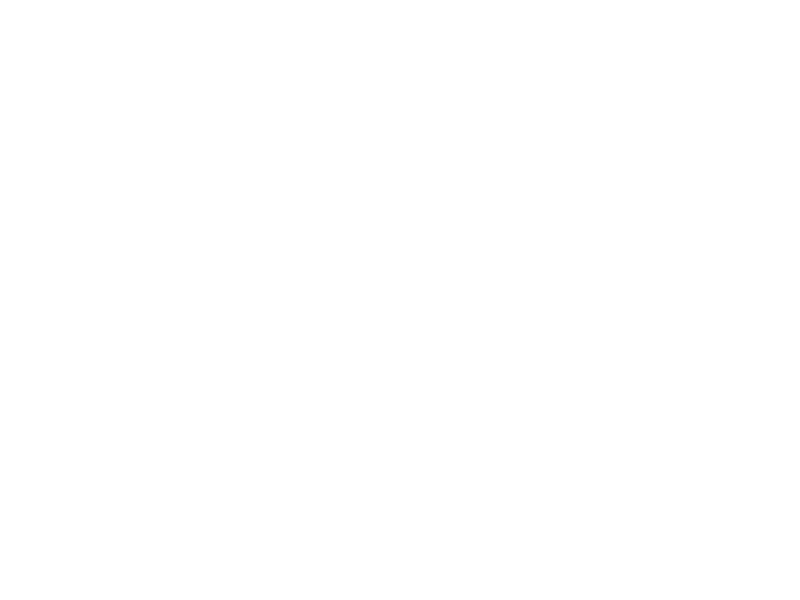

In [30]:
%matplotlib notebook

plt.plot(n_arr, error_lanzcos, '-o', label = "Fehler im Lanczos-Verfahren")

plt.legend()
plt.show()

Das Lanczos-Verfahren produziert diese Fehler, da es numerisch nicht stabil ist. Bei den Berechnungen kann es zu Auslöschug kommen und dadurch geht die Orthogonalität der $v_i$ verloren. Die Idee ist nun, nicht nur mit dem vorherigen Vektor zu reorthogonalisieren, sondern mit allen vorhergehenden. Dadurch erhält man schließlich das Arnoldi-Verfahren.

In [42]:
def arnoldi(A, dim, k = 0):                    #Hier wird die Dimension extra übergeben, da A nicht zwingend eine Matrix sein muss, sondern nur als Funktion übergeben werden kann
    n = dim
    if k == 0:                                 #Falls nicht näher angegeben, werden alle Eigenwerte berechnet
        k = n
        
    v0 = np.random.rand(n)                     #Random-Startvektor wird initialisiert
    v = [v0/np.linalg.norm(v0)]                #Der Vektor wird zusätzlich normiert
    h = np.zeros((k,k))                        #h ist die neue Matrix die erstellt wird, entspricht T aus dem Lanczos-Verfahern
    
    for j in range(k):
        w = A(v[j])                            #Entspricht A@v[j]
        for l in range(j+1):                   #Schleife für Orthogonalisierung nach Gram-Schmidt
            h[l][j] = v[l].T.conj()@w          #Enstpricht v[l]*@w = v[l]*@A@v[j]
            w = w - h[l][j]*v[l]               #Gram-Schmidt Orthogonalisierung
        if j < k-1:                            #Nur im letzten Druchlauf nicht erfüllt
            h[j+1][j] = np.sqrt(w.T.conj()@w)  #sqrt((w,w)) zur Normierung
            if abs(h[j+1][j]) < 1e-14:         #Invarianter Unterraum gefunden, entspricht delta-Bedingung aus Lanczos
                return QR_hesse(h[:j+1,:j+1])  #Eigenwertberechnung der kleineren Matrix
            else:
                v.append(w/h[j+1][j])          #Normierter Vektor wird hinzugefügt
    
    return QR_hesse(h)

Beim Arnoldi-Verfahren erhalten wir nun wesentlich bessere Ergebnisse.

In [43]:
time_arnoldi = [0]*k
error_arnoldi = [0]*k

for i in range(k):
    time_arnoldi[i], error_arnoldi[i] = runtime_error(arnoldi,mat_array[i], eigv_array[i], n_arr[i])

c:\users\salli\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
c:\users\salli\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


<IPython.core.display.Javascript object>


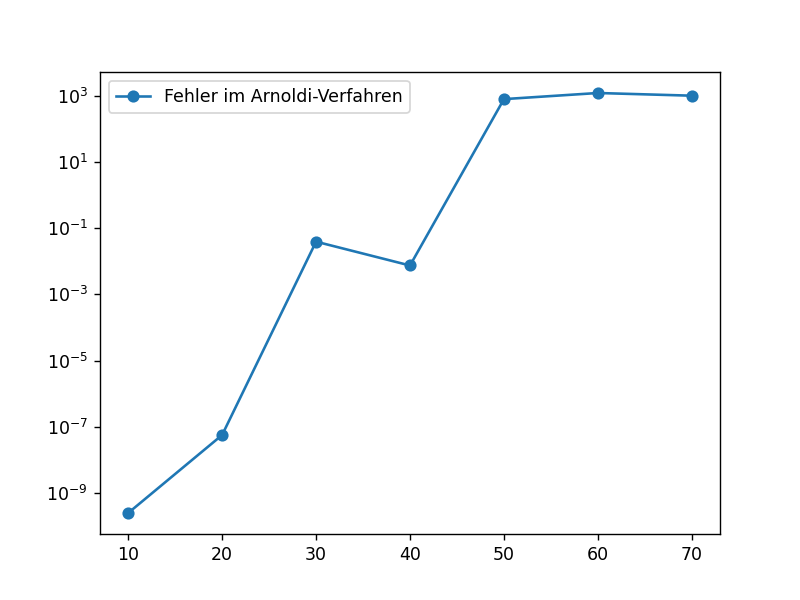

In [45]:
%matplotlib notebook

plt.semilogy(n_arr, error_arnoldi, '-o', label = "Fehler im Arnoldi-Verfahren")

plt.legend()
plt.show()